In [63]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline
def upscaling(Xs, Ys, Y, bins_X, bins_Y):
    """
    Bayesian upscaling from short term data Xs and Ys, with long term data Y, to the hypothetical distribution fX

    Xs: 1D array of the short term target data (grasp)
    Ys: 1D array of the short term reference data (era)
    Y: 1D array of the long term reference data (era)
    bins_X: bin edges for making the pdf's of X
    bins_Y: bin edges for making the pdf's of Y

    returns:
    bin_centers_X: the bin centers of the pdf's of X
    fX_estimate: an estimate of the pdf of the long term target data (what grasp would look like on the long term)
    """
    bin_widths_X = np.ediff1d(bins_X)
    bin_widths_Y = np.ediff1d(bins_Y)

    # marginal pdf's
    # fX, bin_edges_X = np.histogram(X,bins = bins_X)
    # fX = fX/np.size(X)
    fY, bin_edges_Y = np.histogram(Y, bins=bins_Y)
    fY = fY / np.size(Y)
    fXs, bin_edges_X = np.histogram(Xs, bins_X)
    fXs = fXs / np.size(Xs)
    fYs, bin_edges_Y = np.histogram(Ys, bins_Y)
    fYs = fYs / np.size(Ys)

    # joint pdf's
    # fXY, _, _= np.histogram2d(X,Y,[bins_X, bins_Y])
    # fXY = fXY/np.size(X)

    fXsYs, _, _ = np.histogram2d(Xs, Ys, [bins_X, bins_Y])
    fXsYs = fXsYs / np.size(Xs)

    bin_centers_X = 0.5 * (bin_edges_X[1:] + bin_edges_X[:-1])
    bin_centers_Y = 0.5 * (bin_edges_Y[1:] + bin_edges_Y[:-1])

    # apply Bayes's rule
    # the conditional probability is fX|Y = fXY/fY, this is plugged in into the main formula.
    # fX_estimate = np.nansum(fXY/fY[np.newaxis,:]*fY[np.newaxis, :], axis = 1) # truly equal fX, because we're using fXY (this is in fact just integrating fXY)
    fX_estimate = np.nansum(
        fXsYs / fYs[np.newaxis, :] * fY[np.newaxis, :], axis=1
    )  # approximately equals fX, because were using fXsYs/fY as an approximation for fXY/fY
    return bin_centers_X, bin_centers_Y, fXs, fYs, fX_estimate, fY

This notebook contains basic Python code to perform long-term correction as described in ...

### data

In [75]:
# LES data, containing realistic power, free stream power, realistic wind, and free stream wind at 75.3 m.
LES_data = xr.open_dataset('LES_data.nc')
# ERA5
ERA5 = xr.open_dataset("ERA5.nc")

### long-term correction of one year

This entails evaluating:

$\hat{f}_\text{L}(P) \approx \int h_{\text{L | ERA}}(P, M) \hat{g}_\text{ERA}(M)dM$, and:

$ \overline{P} = \int f_\text{L}(P)PdP$.

In the code below, the power and wind are denoted by X and Y, and short term is denotes with an s:
- short term LES power production $\rightarrow$ Xs, and its PDF $f_\text{L}(P)$ $\rightarrow$ fXs
- short term ERA5 wind $\rightarrow$ Ys,  and its PDF $g_\text{ERA}(M)$ $\rightarrow$ fYs
- long term ERA5 wind $\rightarrow$ Y,  and its PDF $\hat{g}_\text{ERA}(M)$ $\rightarrow$ fYs
- the long-term corrected power PDF $\hat{f}_\text{L}(P)\rightarrow$ fX_estimate

/tmp/ipykernel_2193860/566505698.py:46: RuntimeWarning: invalid value encountered in divide
  fXsYs / fYs[np.newaxis, :] * fY[np.newaxis, :], axis=1


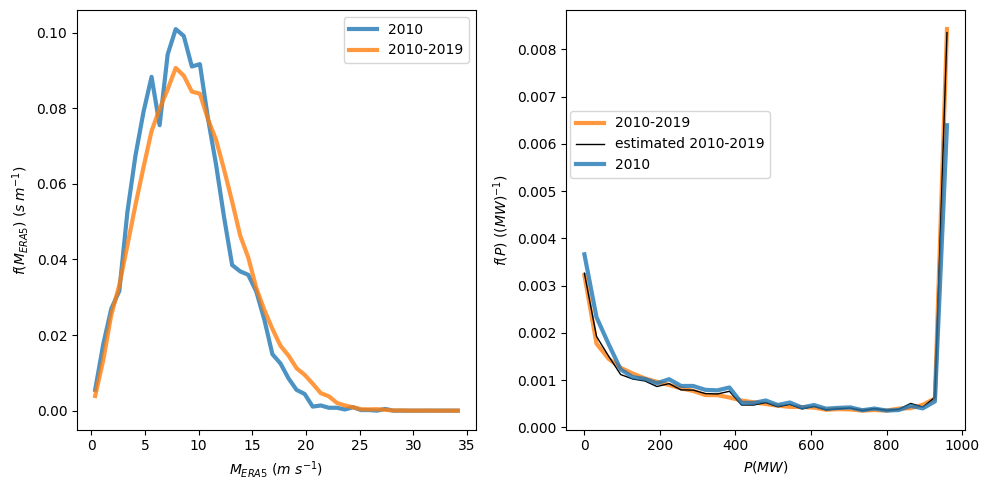

In [76]:
#  correction of one year to 10 years

long_term = slice("2010", "2019")
short_term = '2010'
Xs = LES_data.power.sel(time=short_term)
Ys = ERA5.M.sel(time=short_term)
Y = ERA5.M.sel(time=long_term)
X = LES_data.power.sel(time=long_term)

# binning
bins_Y = np.arange(0, 35, 0.75)
Pr = 9.6e2  # rated power
dP = Pr / 30
bins_X = np.arange(
    -dP / 2, Pr + dP, dP
)  # ensures zero and rated power are at bin centers

# unknown without a 10-year LES run:
fX, bin_edges_X = np.histogram(X, bins=bins_X)
fX = fX / np.size(X)
fXY, _, _ = np.histogram2d(X, Y, [bins_X, bins_Y])
fXY = fXY / np.size(X)

# the long-term correction step 
bin_centers_X, bin_centers_Y, fXs, fYs, fX_estimate, fY = upscaling(
    Xs, Ys, Y, bins_X, bins_Y
)
dY = bin_centers_Y[1] - bin_centers_Y[0]
dX = bin_centers_X[1] - bin_centers_X[0]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.ravel()
ax = axs[0]
ax.plot(bin_centers_Y, fYs / dY, alpha=0.8, label=short_term, linewidth=3)
ax.plot(bin_centers_Y, fY / dY, alpha=0.8, label="2010-2019", linewidth=3)
ax.set_xlabel(r"$M_{ERA5}$ ($m\;s^{-1}$)")
ax.set_ylabel(r"$f(M_{ERA5})$ ($s\;m^{-1}$)")
ax.legend()

ax = axs[1]
ax.plot(bin_centers_X, fX / dP, alpha=0.8, label="2010-2019", linewidth=3, color="C1")
ax.plot(
    bin_centers_X,
    fX_estimate / dP,
    alpha=1,
    color="k",
    linestyle="solid",
    label="estimated 2010-2019",
    linewidth=1,
)
ax.plot(bin_centers_X, fXs / dP, alpha=0.8, label=short_term, linewidth=3, color="C0")
ax.set_ylabel(r"$f(P)$ ($(MW)^{-1}$)")
ax.set_xlabel(r"$P (MW$)")
ax.legend(loc=(0.01, 0.6))

plt.tight_layout()
plt.show()

### calculate mean power

In [20]:
X_long_term_mean_estimate = np.sum(fX_estimate*bin_centers_X) # from the long-term correction
X_long_term_mean = np.sum(fX * bin_centers_X) # from the full 10 years
X_long_term_mean_estimate/X_long_term_mean

1.0009191192124545